# LSTM Trading Strategy - Complete Implementation

This notebook contains the complete implementation of the LSTM Trading Strategy converted from the Python script. Each section contains the actual working code that can be executed.

## Overview
The LSTM Trading Strategy uses deep learning to predict stock price movements and generate trading signals with comprehensive risk management and performance evaluation.

## Features
- LSTM neural network for time series prediction
- Advanced preprocessing with outlier removal and PCA
- Comprehensive trading signal generation
- Risk management with stop-loss and target gains
- Portfolio simulation and performance evaluation
- Detailed visualization and reporting

## Section 1: Import Required Libraries

Import all necessary libraries for the LSTM trading strategy implementation.

In [66]:
"""
LSTM Trading Signal Strategy with Performance Evaluation

This script creates LSTM predictions for stock price movements and evaluates
trading signals with realistic gain/loss calculations, stop losses, and accuracy metrics.
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("✅ Basic libraries imported successfully")

✅ Basic libraries imported successfully


In [67]:
# Deep Learning Libraries with Enhanced Error Handling
print("🔧 Checking and importing deep learning libraries...")

# Check library versions first
import sys
print(f"Python version: {sys.version}")

try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")
except ImportError:
    print("❌ NumPy not found")

try:
    import scipy
    print(f"SciPy version: {scipy.__version__}")
except ImportError:
    print("❌ SciPy not found")

# Try importing TensorFlow with version-specific handling
tensorflow_available = False
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
    
    # Check TensorFlow version compatibility
    tf_version = tuple(map(int, tf.__version__.split('.')[:2]))
    if tf_version >= (2, 10):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        print("✅ TensorFlow 2.10+ imports successful")
    else:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        print("✅ TensorFlow legacy imports successful")
    
    tensorflow_available = True
    
except ImportError as e:
    print(f"❌ TensorFlow import failed: {e}")
    print("💡 Try installing with: pip install tensorflow==2.13.0")
    tensorflow_available = False
except AttributeError as e:
    print(f"⚠️ TensorFlow version compatibility issue: {e}")
    print("💡 This is often due to NumPy/SciPy version conflicts")
    print("💡 Try these solutions:")
    print("   1. pip install numpy==1.24.3 scipy==1.10.1 tensorflow==2.13.0")
    print("   2. Or create a fresh conda environment:")
    print("      conda create -n lstm_trading python=3.9")
    print("      conda activate lstm_trading")
    print("      pip install tensorflow==2.13.0 scikit-learn pandas matplotlib seaborn")
    tensorflow_available = False

# Import scikit-learn libraries
try:
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.decomposition import PCA
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
    from sklearn.ensemble import RandomForestRegressor
    print("✅ scikit-learn imports successful")
except ImportError as e:
    print(f"❌ scikit-learn import failed: {e}")
    print("💡 Try installing with: pip install scikit-learn")

# Import other libraries
try:
    from scipy import stats
    print("✅ SciPy stats import successful")
except ImportError as e:
    print(f"❌ SciPy stats import failed: {e}")

# Summary
if tensorflow_available:
    print("\\n🎉 All deep learning libraries imported successfully!")
    print("You can proceed with the LSTM implementation.")
else:
    print("\\n⚠️ TensorFlow is not available. You have these options:")
    print("1. Fix the environment (recommended)")
    print("2. Use a simpler model (Random Forest, Linear Regression)")
    print("3. Install TensorFlow in a clean environment")
    
    # Provide alternative imports for non-LSTM models
    print("\\n📦 Alternative models available:")
    try:
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.linear_model import LinearRegression
        from sklearn.svm import SVR
        print("✅ Random Forest, Linear Regression, and SVM available")
    except ImportError:
        print("❌ Even basic ML models are not available")

🔧 Checking and importing deep learning libraries...
Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
NumPy version: 2.1.3
SciPy version: 1.15.2
TensorFlow version: 2.19.0
✅ TensorFlow 2.10+ imports successful
✅ scikit-learn imports successful
✅ SciPy stats import successful
\n🎉 All deep learning libraries imported successfully!
You can proceed with the LSTM implementation.


### 🛠️ Troubleshooting Library Issues

If you encountered errors above, here are the most common solutions:

#### **Option 1: Quick Fix (Recommended)**
```bash
pip install --upgrade numpy==1.24.3 scipy==1.10.1 tensorflow==2.13.0
```

#### **Option 2: Clean Environment (Most Reliable)**
```bash
# Create a new conda environment
conda create -n lstm_trading python=3.9
conda activate lstm_trading

# Install packages in correct order
pip install numpy==1.24.3
pip install scipy==1.10.1
pip install tensorflow==2.13.0
pip install scikit-learn pandas matplotlib seaborn
```

#### **Option 3: Use Alternative Models**
If TensorFlow continues to fail, you can modify the strategy to use:
- Random Forest Regressor (good performance, no deep learning)
- Support Vector Regression (SVR)
- Linear Regression with feature engineering

#### **Common Issues:**
1. **NumPy version conflicts**: TensorFlow needs NumPy < 1.25
2. **Python 3.12 compatibility**: Use Python 3.9-3.11 for best compatibility
3. **Windows path issues**: Use forward slashes in file paths

#### **Next Steps:**
- If imports work: Continue with the notebook
- If imports fail: Try the solutions above
- For immediate testing: Skip to the alternative models section

In [68]:
# Visualization and Utility Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Visualization and utility libraries imported successfully")

✅ Visualization and utility libraries imported successfully


## Section 2: LSTMTradingStrategy Class Definition

Complete implementation of the LSTM Trading Strategy class with all methods.

In [69]:
class LSTMTradingStrategy:
    def __init__(self, 
                 sequence_length=60,
                 target_horizon=5,
                 target_gain=0.10,
                 stop_loss=-0.03,
                 test_split=0.2,
                 use_advanced_preprocessing=True,
                 outlier_threshold=1.5,
                 pca_variance_threshold=0.95):
        """
        Initialize LSTM Trading Strategy
        
        Parameters:
        sequence_length: Number of days to look back for LSTM input
        target_horizon: Number of days to hold position
        target_gain: Target profit percentage (10% = 0.10)
        stop_loss: Stop loss percentage (-3% = -0.03)
        test_split: Percentage of data for testing
        use_advanced_preprocessing: Enable advanced preprocessing
        outlier_threshold: IQR multiplier for outlier detection
        pca_variance_threshold: Minimum variance to retain in PCA
        """
        self.sequence_length = sequence_length
        self.target_horizon = target_horizon
        self.target_gain = target_gain
        self.stop_loss = stop_loss
        self.test_split = test_split
        self.use_advanced_preprocessing = use_advanced_preprocessing
        self.outlier_threshold = outlier_threshold
        self.pca_variance_threshold = pca_variance_threshold
        
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.pca = None
        self.model = None
        self.history = None
        
        print("✅ LSTMTradingStrategy initialized with parameters:")
        print(f"   Sequence length: {sequence_length}")
        print(f"   Target horizon: {target_horizon} days")
        print(f"   Target gain: {target_gain*100}%")
        print(f"   Stop loss: {stop_loss*100}%")
        print(f"   Advanced preprocessing: {use_advanced_preprocessing}")
        
    def handle_missing_values_advanced(self, data_df):
        """Handle missing values using linear interpolation"""
        print("🔧 Applying linear interpolation for missing values...")
        
        missing_before = data_df.isnull().sum().sum()
        
        if missing_before > 0:
            print(f"   Found {missing_before} missing values")
            data_df = data_df.interpolate(method='linear', limit_direction='both')
            data_df = data_df.fillna(method='ffill').fillna(method='bfill')
            
            missing_after = data_df.isnull().sum().sum()
            print(f"   Missing values after interpolation: {missing_after}")
        else:
            print("   No missing values found")
            
        return data_df
    
    def remove_outliers_iqr(self, data_df):
        """Remove outliers using IQR-based filtering"""
        print(f"🔧 Removing outliers using IQR method (threshold: {self.outlier_threshold})...")
        
        rows_before = len(data_df)
        outlier_counts = {}
        
        for column in data_df.columns:
            Q1 = data_df[column].quantile(0.25)
            Q3 = data_df[column].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - self.outlier_threshold * IQR
            upper_bound = Q3 + self.outlier_threshold * IQR
            
            outliers = ((data_df[column] < lower_bound) | (data_df[column] > upper_bound)).sum()
            if outliers > 0:
                outlier_counts[column] = outliers
        
        if outlier_counts:
            print(f"   Outliers detected per feature: {outlier_counts}")
            
            for column in data_df.columns:
                Q1 = data_df[column].quantile(0.25)
                Q3 = data_df[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.outlier_threshold * IQR
                upper_bound = Q3 + self.outlier_threshold * IQR
                
                data_df = data_df[(data_df[column] >= lower_bound) & (data_df[column] <= upper_bound)]
        
        rows_after = len(data_df)
        rows_removed = rows_before - rows_after
        
        print(f"   Rows removed: {rows_removed} ({rows_removed/rows_before*100:.1f}%)")
        print(f"   Rows remaining: {rows_after}")
        
        return data_df
    
    def apply_pca_reduction(self, data):
        """Apply PCA for dimensionality reduction"""
        if data.shape[1] <= 2:
            print("🔧 Skipping PCA: Too few features for dimensionality reduction")
            return data
            
        print(f"🔧 Applying PCA (retaining {self.pca_variance_threshold*100}% variance)...")
        
        features_before = data.shape[1]
        
        self.pca = PCA(n_components=self.pca_variance_threshold)
        data_pca = self.pca.fit_transform(data)
        
        features_after = data_pca.shape[1]
        variance_explained = self.pca.explained_variance_ratio_.sum()
        
        print(f"   Features reduced: {features_before} → {features_after}")
        print(f"   Variance explained: {variance_explained:.3f} ({variance_explained*100:.1f}%)")
        
        return data_pca

print("✅ LSTMTradingStrategy class and helper methods defined successfully")

✅ LSTMTradingStrategy class and helper methods defined successfully


In [81]:
def prepare_data(self, df, features=['close']):
        """Prepare data for LSTM training with advanced preprocessing options"""
        print("🚀 Preparing data for LSTM with advanced preprocessing...")
        
        # Ensure we have the required columns
        feature_cols = []
        for feature in features:
            if feature.lower() in [col.lower() for col in df.columns]:
                actual_col = next(col for col in df.columns if col.lower() == feature.lower())
                feature_cols.append(actual_col)
            else:
                print(f"Warning: Feature '{feature}' not found in data")
        
        if not feature_cols:
            raise ValueError("No valid features found in the data")
        
        # Sort by date if date column exists
        if 'date' in [col.lower() for col in df.columns]:
            date_col = next(col for col in df.columns if col.lower() == 'date')
            df = df.sort_values(date_col)
        
        # Extract features into DataFrame for advanced preprocessing
        data_df = df[feature_cols].copy()
        print(f"📊 Initial data shape: {data_df.shape}")
        
        if self.use_advanced_preprocessing:
            print("\n🔧 ADVANCED PREPROCESSING PIPELINE:")
            
            # Step 1: Handle missing values with linear interpolation
            data_df = self.handle_missing_values_advanced(data_df)
            
            # Step 2: Remove outliers using IQR-based filtering
            data_df = self.remove_outliers_iqr(data_df)
            
            print(f"📊 Data shape after outlier removal: {data_df.shape}")
            
            # Ensure we still have enough data
            if len(data_df) < self.sequence_length * 5:
                print("⚠️  Warning: Limited data after outlier removal. Consider adjusting outlier_threshold.")
            
            # Convert back to numpy array for scaling
            data = data_df.values
            
            # Step 3: Normalize features via Min-Max scaling
            print("🔧 Applying Min-Max scaling...")
            scaled_data = self.scaler.fit_transform(data)
            
            # Step 4: Apply PCA for dimensionality reduction
            if len(feature_cols) > 2:
                scaled_data = self.apply_pca_reduction(scaled_data)
            
        else:
            print("\n📝 BASIC PREPROCESSING:")
            data = data_df.values
            
            # Handle missing values (basic approach)
            if np.isnan(data).any():
                print("🔧 Handling missing values with forward/backward fill...")
                data_df = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill')
                data = data_df.values
            
            # Scale the data
            print("🔧 Applying Min-Max scaling...")
            scaled_data = self.scaler.fit_transform(data)
        
        print(f"📊 Final preprocessed data shape: {scaled_data.shape}")
        
        # Create sequences for LSTM
        print("🔧 Creating LSTM sequences...")
        X, y = [], []
        for i in range(self.sequence_length, len(scaled_data)):
            X.append(scaled_data[i-self.sequence_length:i])
            y.append(scaled_data[i, 0])  # Predict the first feature (close price)
        
        X, y = np.array(X), np.array(y)
        
        # Split into train and test
        split_idx = int(len(X) * (1 - self.test_split))
        
        self.X_train = X[:split_idx]
        self.X_test = X[split_idx:]
        self.y_train = y[:split_idx]
        self.y_test = y[split_idx:]
        
        # Store original data for evaluation
        self.original_data = df[feature_cols[0]].values
        self.test_start_idx = len(scaled_data) - len(self.y_test)
        
        print(f"✅ Data preparation complete:")
        print(f"   Training samples: {len(self.X_train)}")
        print(f"   Test samples: {len(self.X_test)}")
        print(f"   Feature dimensions: {self.X_train.shape[2]}")
        print(f"   Advanced preprocessing: {'Enabled' if self.use_advanced_preprocessing else 'Disabled'}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test

# Add the method to the class
LSTMTradingStrategy.prepare_data = prepare_data

print("✅ Data preparation method added successfully")

✅ Data preparation method added successfully


In [82]:
def build_model(self, lstm_units=[50, 50], dropout_rate=0.2):
    """Build LSTM model"""
    print("Building LSTM model...")
    
    self.model = Sequential()
    
    # First LSTM layer
    self.model.add(LSTM(units=lstm_units[0], 
                       return_sequences=True if len(lstm_units) > 1 else False,
                       input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
    self.model.add(Dropout(dropout_rate))
    
    # Additional LSTM layers
    for i, units in enumerate(lstm_units[1:], 1):
        return_seq = i < len(lstm_units) - 1
        self.model.add(LSTM(units=units, return_sequences=return_seq))
        self.model.add(Dropout(dropout_rate))
    
    # Output layer
    self.model.add(Dense(1))
    
    # Compile model
    self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    print("Model architecture:")
    self.model.summary()
    
    return self.model

def train_model(self, epochs=50, batch_size=32, validation_split=0.1, verbose=1):
        """Train the LSTM model"""
        print("Training LSTM model...")
        
        # Callbacks for better training
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ]
        
        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=verbose
        )
        
        print("Model training completed!")
        return self.history

def inverse_transform_price(self, scaled_values):
    """Helper function to properly inverse transform price values"""
    if np.isscalar(scaled_values):
        scaled_values = [scaled_values]
    
    # If PCA was applied, handle transformation differently
    if self.pca is not None:
        # For PCA case, approximate the inverse transform
        dummy_pca = np.zeros((len(scaled_values), self.pca.n_components_))
        dummy_pca[:, 0] = scaled_values
        
        # Inverse PCA transform
        dummy_original = self.pca.inverse_transform(dummy_pca)
        
        # Inverse scale using the first feature (price)
        dummy_for_scaler = np.zeros((len(scaled_values), self.scaler.n_features_in_))
        dummy_for_scaler[:, 0] = dummy_original[:, 0]
        
        return self.scaler.inverse_transform(dummy_for_scaler)[:, 0]
    else:
        # Original approach for non-PCA case
        dummy = np.zeros((len(scaled_values), self.scaler.n_features_in_))
        dummy[:, 0] = scaled_values
        
        return self.scaler.inverse_transform(dummy)[:, 0]

def make_predictions(self):
    """Make predictions on test data"""
    print("Making predictions...")
    
    # Predict on test data
    y_pred_scaled = self.model.predict(self.X_test)
    
    # Inverse transform predictions
    y_pred = self.inverse_transform_price(y_pred_scaled.flatten())
    
    # Inverse transform actual values
    y_actual = self.inverse_transform_price(self.y_test)
    
    self.y_pred = y_pred
    self.y_actual = y_actual
    
    # Calculate basic metrics
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"Prediction Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    return y_pred, y_actual

# Add the methods to the class
LSTMTradingStrategy.build_model = build_model
LSTMTradingStrategy.train_model = train_model
LSTMTradingStrategy.inverse_transform_price = inverse_transform_price
LSTMTradingStrategy.make_predictions = make_predictions

print("✅ Model building, training, and prediction methods added successfully")

✅ Model building, training, and prediction methods added successfully


In [83]:
def generate_trading_signals(self, df):
        """Generate comprehensive trading signals and evaluate performance"""
        print("Generating comprehensive trading signals...")
        
        # Get the actual close prices for the test period
        close_col = next(col for col in df.columns if col.lower() == 'close')
        all_close_prices = df[close_col].values
        
        # Get close prices for test period
        test_close_prices = all_close_prices[self.test_start_idx + self.sequence_length:]
        
        # Debug information
        print(f"Debug info:")
        print(f"  y_pred length: {len(self.y_pred)}")
        print(f"  test_close_prices length: {len(test_close_prices)}")
        print(f"  target_horizon: {self.target_horizon}")
        
        # Safety check
        if len(self.y_pred) < self.target_horizon or len(test_close_prices) < self.target_horizon:
            print("⚠️ Warning: Insufficient data for signal generation")
            return []
        
        # Ensure we have date information
        if hasattr(df.index, 'strftime'):
            test_dates = df.index[self.test_start_idx + self.sequence_length:]
        elif 'date' in [col.lower() for col in df.columns]:
            date_col = next(col for col in df.columns if col.lower() == 'date')
            test_dates = df[date_col].iloc[self.test_start_idx + self.sequence_length:]
        else:
            test_dates = pd.date_range(start='2023-01-01', periods=len(test_close_prices), freq='D')
        
        results = []
        portfolio_value = 100000  # Starting portfolio value
        current_portfolio = portfolio_value
        
        # Generate signals
        max_signals = min(len(self.y_pred), len(test_close_prices)) - self.target_horizon
        max_signals = max(0, max_signals)
        
        print(f"Generating signals for {max_signals} trading opportunities...")
        
        for i in range(max_signals):
            # Current and future predictions
            current_pred_scaled = self.inverse_transform_price([self.y_pred[i]])[0]
            if i + 1 < len(self.y_pred):
                future_pred_scaled = self.inverse_transform_price([self.y_pred[i + 1]])[0]
            else:
                future_pred_scaled = current_pred_scaled
            
            # Current and target prices
            start_price = test_close_prices[i]
            target_price = test_close_prices[i + self.target_horizon] if i + self.target_horizon < len(test_close_prices) else start_price
            
            # Calculate prediction confidence
            pred_change = (future_pred_scaled - current_pred_scaled) / current_pred_scaled if current_pred_scaled != 0 else 0
            confidence = min(abs(pred_change) * 100, 100)
            
            # Determine signal
            signal_strength = "Strong" if confidence > 2.0 else "Medium" if confidence > 1.0 else "Weak"
            predicted_trend = 'BUY' if future_pred_scaled > current_pred_scaled else 'SELL'
            actual_trend = 'BUY' if target_price > start_price else 'SELL'
            
            # Calculate performance metrics
            pct_change = (target_price - start_price) / start_price if start_price != 0 else 0
            gain_loss = pct_change * 100
            correct_prediction = predicted_trend == actual_trend
            
            # Simulate realistic trading
            exit_price = target_price
            exit_reason = "Target_Duration"
            actual_duration = self.target_horizon
            max_gain_during_period = 0
            max_loss_during_period = 0
            
            # Check intraday performance
            for day in range(1, min(self.target_horizon + 1, len(test_close_prices) - i)):
                if i + day < len(test_close_prices):
                    daily_price = test_close_prices[i + day]
                    daily_return = (daily_price - start_price) / start_price if start_price != 0 else 0
                    
                    max_gain_during_period = max(max_gain_during_period, daily_return * 100)
                    max_loss_during_period = min(max_loss_during_period, daily_return * 100)
                    
                    # Check stop loss and target gain
                    if daily_return <= self.stop_loss:
                        exit_price = daily_price
                        exit_reason = "Stop_Loss"
                        actual_duration = day
                        break
                    elif daily_return >= self.target_gain:
                        exit_price = daily_price
                        exit_reason = "Target_Gain"
                        actual_duration = day
                        break
            
            # Calculate risk metrics
            volatility = max_gain_during_period - max_loss_during_period
            risk_reward_ratio = abs(self.target_gain / self.stop_loss) if self.stop_loss != 0 else 0
            
            # Portfolio simulation
            trade_value = current_portfolio * 0.1  # Risk 10% per trade
            shares = trade_value / start_price if start_price != 0 else 0
            trade_profit = shares * (exit_price - start_price)
            current_portfolio += trade_profit
            
            # Additional metrics
            holding_period_return = gain_loss
            annualized_return = (gain_loss / actual_duration) * 252 if actual_duration > 0 else 0
            
            # Date formatting
            try:
                if hasattr(test_dates.iloc[i], 'strftime'):
                    date_str = test_dates.iloc[i].strftime('%Y-%m-%d')
                else:
                    date_str = str(test_dates.iloc[i])[:10]
            except:
                date_str = f"Day_{i}"
            
            # Create comprehensive signal record
            signal_record = {
                'Signal_ID': i + 1,
                'Date': date_str,
                'Signal_Type': predicted_trend,
                'Signal_Strength': signal_strength,
                'Confidence_Score': confidence,
                
                'Entry_Price': start_price,
                'Exit_Price': exit_price,
                'Predicted_Price': future_pred_scaled,
                'Target_Price': target_price,
                'Stop_Loss_Price': start_price * (1 + self.stop_loss),
                
                'Actual_Gain_Loss_Pct': gain_loss,
                'Max_Gain_During_Period': max_gain_during_period,
                'Max_Loss_During_Period': max_loss_during_period,
                'Volatility_During_Period': volatility,
                
                'Prediction_Accuracy': 'Correct' if correct_prediction else 'Incorrect',
                'Target_Hit': exit_reason == "Target_Gain",
                'Stop_Loss_Hit': exit_reason == "Stop_Loss",
                'Exit_Reason': exit_reason,
                'Actual_Duration': actual_duration,
                'Holding_Period_Return': holding_period_return,
                'Annualized_Return': annualized_return,
                'Risk_Reward_Ratio': risk_reward_ratio,
                
                'Portfolio_Value': current_portfolio,
                'Trade_Profit': trade_profit,
                'Trade_Value': trade_value,
                'Shares_Traded': shares
            }
            
            results.append(signal_record)
        
        # Convert to DataFrame and store
        self.results_df = pd.DataFrame(results)
        
        # Calculate summary statistics
        if results:
            total_trades = len(results)
            correct_predictions = sum(1 for r in results if r['Prediction_Accuracy'] == 'Correct')
            accuracy = (correct_predictions / total_trades) * 100 if total_trades > 0 else 0
            
            avg_gain = np.mean([r['Actual_Gain_Loss_Pct'] for r in results])
            avg_duration = np.mean([r['Actual_Duration'] for r in results])
            total_return = ((current_portfolio - portfolio_value) / portfolio_value) * 100
            
            print(f"\n📊 Trading Strategy Summary:")
            print(f"   Total Trades: {total_trades}")
            print(f"   Accuracy: {accuracy:.1f}%")
            print(f"   Average Gain/Loss: {avg_gain:.2f}%")
            print(f"   Average Duration: {avg_duration:.1f} days")
            print(f"   Total Return: {total_return:.2f}%")
            print(f"   Final Portfolio Value: ${current_portfolio:,.2f}")
        
        return self.results_df

# Add the method to the class
LSTMTradingStrategy.generate_trading_signals = generate_trading_signals

print("✅ Trading signals generation method added successfully")

✅ Trading signals generation method added successfully


In [84]:
def calculate_summary_statistics(self):
    """Calculate comprehensive strategy performance metrics"""
    if not hasattr(self, 'results_df') or self.results_df.empty:
        return {}
    
    df = self.results_df
    
    # Basic statistics
    total_signals = len(df)
    correct_predictions = (df['Prediction_Accuracy'] == 'Correct').sum()
    overall_accuracy = (correct_predictions / total_signals) * 100 if total_signals > 0 else 0
    
    # Signal type performance
    bullish_signals = (df['Signal_Type'] == 'BUY').sum()
    bearish_signals = (df['Signal_Type'] == 'SELL').sum()
    
    bullish_correct = ((df['Signal_Type'] == 'BUY') & (df['Prediction_Accuracy'] == 'Correct')).sum()
    bearish_correct = ((df['Signal_Type'] == 'SELL') & (df['Prediction_Accuracy'] == 'Correct')).sum()
    
    bullish_accuracy = (bullish_correct / bullish_signals) * 100 if bullish_signals > 0 else 0
    bearish_accuracy = (bearish_correct / bearish_signals) * 100 if bearish_signals > 0 else 0
    
    # Return statistics
    correct_mask = df['Prediction_Accuracy'] == 'Correct'
    avg_gain_when_correct = df[correct_mask]['Actual_Gain_Loss_Pct'].mean() if correct_mask.any() else 0
    avg_loss_when_incorrect = df[~correct_mask]['Actual_Gain_Loss_Pct'].mean() if (~correct_mask).any() else 0
    total_return = df['Actual_Gain_Loss_Pct'].sum()
    
    # Risk metrics
    target_hits = (df['Target_Hit'] == True).sum()
    stop_losses = (df['Stop_Loss_Hit'] == True).sum()
    avg_duration = df['Actual_Duration'].mean()
    
    # Win/Loss analysis
    wins = (df['Actual_Gain_Loss_Pct'] > 0).sum()
    losses = (df['Actual_Gain_Loss_Pct'] < 0).sum()
    win_rate = (wins / total_signals) * 100 if total_signals > 0 else 0
    
    avg_win = df[df['Actual_Gain_Loss_Pct'] > 0]['Actual_Gain_Loss_Pct'].mean() if wins > 0 else 0
    avg_loss = df[df['Actual_Gain_Loss_Pct'] < 0]['Actual_Gain_Loss_Pct'].mean() if losses > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    # Volatility and Sharpe ratio
    returns_std = df['Actual_Gain_Loss_Pct'].std() if total_signals > 0 else 0
    mean_return = df['Actual_Gain_Loss_Pct'].mean() if total_signals > 0 else 0
    sharpe_ratio = mean_return / returns_std if returns_std != 0 else 0
    
    summary = {
        'Total_Signals': total_signals,
        'Correct_Predictions': correct_predictions,
        'Overall_Accuracy_Pct': round(overall_accuracy, 2),
        'Bullish_Signals': bullish_signals,
        'Bearish_Signals': bearish_signals,
        'Bullish_Accuracy_Pct': round(bullish_accuracy, 2),
        'Bearish_Accuracy_Pct': round(bearish_accuracy, 2),
        'Avg_Gain_When_Correct_Pct': round(avg_gain_when_correct, 2),
        'Avg_Loss_When_Incorrect_Pct': round(avg_loss_when_incorrect, 2),
        'Total_Return_Pct': round(total_return, 2),
        'Target_Hits': target_hits,
        'Stop_Losses': stop_losses,
        'Average_Duration_Days': round(avg_duration, 1),
        'Win_Rate_Pct': round(win_rate, 2),
        'Average_Win_Pct': round(avg_win, 2),
        'Average_Loss_Pct': round(avg_loss, 2),
        'Profit_Factor': round(profit_factor, 2),
        'Volatility_Pct': round(returns_std, 2),
        'Sharpe_Ratio': round(sharpe_ratio, 2)
    }
    
    return summary

def plot_results(self, save_path='../output/'):
    """Create comprehensive visualizations of strategy performance"""
    if not hasattr(self, 'results_df') or self.results_df.empty:
        print("No results to plot")
        return
    
    # Create output directory
    os.makedirs(save_path, exist_ok=True)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('LSTM Trading Strategy Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Predictions vs Actual
    axes[0, 0].plot(self.y_actual[:100], label='Actual', alpha=0.8)
    axes[0, 0].plot(self.y_pred[:100], label='Predicted', alpha=0.8)
    axes[0, 0].set_title('Price Predictions vs Actual (First 100 days)')
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy by Signal Type
    accuracy_data = self.results_df.groupby('Signal_Type').apply(
        lambda x: (x['Prediction_Accuracy'] == 'Correct').mean() * 100
    )
    accuracy_data.plot(kind='bar', ax=axes[0, 1], color=['red', 'green'])
    axes[0, 1].set_title('Accuracy by Signal Type')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_xticklabels(accuracy_data.index, rotation=0)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Return Distribution
    axes[0, 2].hist(self.results_df['Actual_Gain_Loss_Pct'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 2].axvline(0, color='red', linestyle='--', label='Break Even')
    axes[0, 2].axvline(self.target_gain*100, color='green', linestyle='--', label=f'Target ({self.target_gain*100}%)')
    axes[0, 2].axvline(self.stop_loss*100, color='orange', linestyle='--', label=f'Stop Loss ({self.stop_loss*100}%)')
    axes[0, 2].set_title('Return Distribution')
    axes[0, 2].set_xlabel('Return (%)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Cumulative Returns
    cumulative_returns = self.results_df['Actual_Gain_Loss_Pct'].cumsum()
    axes[1, 0].plot(cumulative_returns, color='purple', linewidth=2)
    axes[1, 0].set_title('Cumulative Returns')
    axes[1, 0].set_xlabel('Trade Number')
    axes[1, 0].set_ylabel('Cumulative Return (%)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Training History
    if hasattr(self, 'history') and self.history:
        axes[1, 1].plot(self.history.history['loss'], label='Training Loss')
        if 'val_loss' in self.history.history:
            axes[1, 1].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[1, 1].set_title('Training History')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Win/Loss Analysis
    win_loss_data = pd.DataFrame({
        'Type': ['Wins', 'Losses'],
        'Count': [
            (self.results_df['Actual_Gain_Loss_Pct'] > 0).sum(),
            (self.results_df['Actual_Gain_Loss_Pct'] < 0).sum()
        ]
    })
    win_loss_data.plot(x='Type', y='Count', kind='bar', ax=axes[1, 2], color=['green', 'red'])
    axes[1, 2].set_title('Win/Loss Distribution')
    axes[1, 2].set_xlabel('Outcome')
    axes[1, 2].set_ylabel('Number of Trades')
    axes[1, 2].set_xticklabels(win_loss_data['Type'], rotation=0)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot
    save_file = os.path.join(save_path, f'lstm_strategy_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualizations saved to: {save_file}")

def save_results(self, save_path='../output/'):
    """Save results to CSV and text files"""
    if not hasattr(self, 'results_df') or self.results_df.empty:
        print("No results to save")
        return
    
    # Create output directory
    os.makedirs(save_path, exist_ok=True)
    
    # Save detailed signals
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    signals_file = os.path.join(save_path, f'lstm_signals_{timestamp}.csv')
    self.results_df.to_csv(signals_file, index=False)
    
    # Save summary statistics
    summary = self.calculate_summary_statistics()
    summary_file = os.path.join(save_path, f'lstm_summary_{timestamp}.csv')
    pd.DataFrame([summary]).to_csv(summary_file, index=False)
    
    # Create detailed report
    report_file = os.path.join(save_path, f'lstm_report_{timestamp}.txt')
    with open(report_file, 'w') as f:
        f.write("LSTM Trading Strategy Performance Report\\n")
        f.write("=" * 50 + "\\n\\n")
        
        f.write("Strategy Parameters:\\n")
        f.write(f"  Sequence Length: {self.sequence_length}\\n")
        f.write(f"  Target Horizon: {self.target_horizon} days\\n")
        f.write(f"  Target Gain: {self.target_gain*100}%\\n")
        f.write(f"  Stop Loss: {self.stop_loss*100}%\\n")
        f.write(f"  Advanced Preprocessing: {self.use_advanced_preprocessing}\\n\\n")
        
        f.write("Performance Summary:\\n")
        for key, value in summary.items():
            f.write(f"  {key.replace('_', ' ')}: {value}\\n")
        
        f.write("\\nTop 5 Best Performing Signals:\\n")
        top_signals = self.results_df.nlargest(5, 'Actual_Gain_Loss_Pct')
        f.write(top_signals[['Date', 'Signal_Type', 'Actual_Gain_Loss_Pct', 'Exit_Reason']].to_string(index=False))
        
        f.write("\\n\\nTop 5 Worst Performing Signals:\\n")
        worst_signals = self.results_df.nsmallest(5, 'Actual_Gain_Loss_Pct')
        f.write(worst_signals[['Date', 'Signal_Type', 'Actual_Gain_Loss_Pct', 'Exit_Reason']].to_string(index=False))
    
    print(f"✅ Results saved:")
    print(f"   Signals: {signals_file}")
    print(f"   Summary: {summary_file}")
    print(f"   Report: {report_file}")
    
    return signals_file, summary_file, report_file

# Add the methods to the class
LSTMTradingStrategy.calculate_summary_statistics = calculate_summary_statistics
LSTMTradingStrategy.plot_results = plot_results
LSTMTradingStrategy.save_results = save_results

print("✅ Performance evaluation and visualization methods added successfully")

✅ Performance evaluation and visualization methods added successfully


## Section 3: Main Execution Function

Function to run the complete LSTM trading strategy workflow.

In [74]:
def run_lstm_trading_strategy(data_file='data/processed/stock_data_with_technical_indicators.csv',
                             company_id=None,
                             target_horizon=5,
                             target_gain=0.10,
                             stop_loss=-0.03,
                             use_advanced_preprocessing=True,
                             outlier_threshold=1.5,
                             pca_variance_threshold=0.95,
                             sequence_length=60,
                             lstm_units=[100, 50],
                             epochs=50,
                             batch_size=32,
                             verbose=1):
    """
    Run the complete LSTM trading strategy
    
    Parameters:
    -----------
    data_file : str
        Path to the CSV file containing stock data with technical indicators
    company_id : str, optional
        Specific company to analyze (None = use first company in data)
    target_horizon : int
        Number of days to hold position (default: 5)
    target_gain : float
        Target profit percentage (default: 0.10 = 10%)
    stop_loss : float
        Stop loss percentage (default: -0.03 = -3%)
    use_advanced_preprocessing : bool
        Enable advanced preprocessing pipeline (default: True)
    outlier_threshold : float
        IQR multiplier for outlier detection (default: 1.5)
    pca_variance_threshold : float
        Minimum variance to retain in PCA (default: 0.95)
    sequence_length : int
        LSTM sequence length (default: 60)
    lstm_units : list
        LSTM layer units (default: [100, 50])
    epochs : int
        Training epochs (default: 50)
    batch_size : int
        Training batch size (default: 32)
    verbose : int
        Training verbosity (default: 1)
    
    Returns:
    --------
    tuple
        (strategy_object, signals_dataframe, summary_statistics)
    """
    
    print("🚀 Starting LSTM Trading Strategy...")
    print(f"📂 Loading data from: {data_file}")
    
    # Load data
    df = pd.read_csv(data_file)
    print(f"📊 Data loaded successfully. Shape: {df.shape}")
    
    # Filter to specific company if requested
    if company_id:
        if 'company' in df.columns:
            df = df[df['company'] == company_id]
            print(f"📊 Filtered to company: {company_id}. Shape: {df.shape}")
        else:
            print("⚠️ Warning: 'company' column not found. Using all data.")
    else:
        # Use first company if multiple companies exist
        if 'company' in df.columns:
            companies = df['company'].unique()
            if len(companies) > 1:
                first_company = companies[0]
                df = df[df['company'] == first_company]
                print(f"📊 Multiple companies found. Using first: {first_company}")
    
    # Ensure we have enough data
    if len(df) < sequence_length * 10:
        print("⚠️ Warning: Limited data available. Results may not be reliable.")
    
    # Initialize strategy
    strategy = LSTMTradingStrategy(
        sequence_length=sequence_length,
        target_horizon=target_horizon,
        target_gain=target_gain,
        stop_loss=stop_loss,
        use_advanced_preprocessing=use_advanced_preprocessing,
        outlier_threshold=outlier_threshold,
        pca_variance_threshold=pca_variance_threshold
    )
    
    # Define priority technical indicators
    priority_indicators = [
        'close',  # Essential
        'rsi', 'roc', 'stoch_k', 'stoch_d', 'tsi',  # Momentum
        'obv', 'mfi', 'pvt',  # Volume
        'macd', 'tema', 'kama',  # Trend
        'atr', 'bb_position', 'ulcer_index'  # Volatility
    ]
    
    # Find available indicators
    available_indicators = [ind for ind in priority_indicators if ind in df.columns]
    if not available_indicators:
        available_indicators = ['close']  # Fallback to close price only
    
    print(f"📊 Using indicators: {available_indicators}")
    
    # Prepare data
    strategy.prepare_data(df, features=available_indicators)
    
    # Build and train model
    strategy.build_model(lstm_units=lstm_units, dropout_rate=0.2)
    strategy.train_model(epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # Make predictions
    strategy.make_predictions()
    
    # Generate trading signals
    signals_df = strategy.generate_trading_signals(df)
    
    # Calculate summary statistics
    summary = strategy.calculate_summary_statistics()
    
    # Display results
    print("\\n📊 TRADING SIGNALS SAMPLE:")
    if not signals_df.empty:
        display_cols = ['Date', 'Signal_Type', 'Confidence_Score', 'Actual_Gain_Loss_Pct', 
                       'Exit_Reason', 'Prediction_Accuracy']
        print(signals_df[display_cols].head(10).to_string(index=False))
    
    print("\\n📈 PERFORMANCE SUMMARY:")
    for key, value in summary.items():
        print(f"  {key.replace('_', ' ')}: {value}")
    
    # Save results and create visualizations
    strategy.save_results()
    strategy.plot_results()
    
    return strategy, signals_df, summary

print("✅ Main execution function defined successfully")

✅ Main execution function defined successfully


## Section 4: Example Usage

Example of how to use the LSTM Trading Strategy with your data.

In [75]:
# Example 1: Basic Usage
# Uncomment the following lines to run the strategy

# strategy, signals_df, summary = run_lstm_trading_strategy(
#     data_file='data/processed/stock_data_with_technical_indicators.csv',
#     target_horizon=5,      # Hold position for 5 days
#     target_gain=0.10,      # Target 10% gain
#     stop_loss=-0.03,       # Stop loss at -3%
#     epochs=50,             # Training epochs
#     verbose=1              # Show training progress
# )

print("Example usage code ready. Uncomment the lines above to run the strategy.")
print("Make sure your data file exists at the specified path.")

Example usage code ready. Uncomment the lines above to run the strategy.
Make sure your data file exists at the specified path.


In [76]:
# Example 2: Advanced Configuration
# Uncomment to run with custom parameters

# strategy, signals_df, summary = run_lstm_trading_strategy(
#     data_file='data/processed/stock_data_with_technical_indicators.csv',
#     company_id='AAPL',             # Specific company
#     target_horizon=10,             # Hold for 10 days
#     target_gain=0.15,              # Target 15% gain
#     stop_loss=-0.05,               # Stop loss at -5%
#     sequence_length=90,            # 90-day lookback
#     lstm_units=[150, 100, 50],     # 3-layer LSTM
#     epochs=100,                    # More training
#     batch_size=64,                 # Larger batch size
#     use_advanced_preprocessing=True, # Enable all preprocessing
#     outlier_threshold=2.0,         # More conservative outlier removal
#     pca_variance_threshold=0.98,   # Retain 98% variance
#     verbose=1
# )

print("Advanced configuration example ready.")
print("This configuration uses more sophisticated parameters for potentially better results.")

Advanced configuration example ready.
This configuration uses more sophisticated parameters for potentially better results.


## Section 5: Testing the Implementation

This section demonstrates how to test the implementation with sample data or check if your data is compatible.

In [77]:
# Test 1: Check if data file exists
import os

data_file = 'data/processed/stock_data_with_technical_indicators.csv'
if os.path.exists(data_file):
    print(f"✅ Data file found: {data_file}")
    
    # Load and inspect the data
    df = pd.read_csv(data_file)
    print(f"📊 Data shape: {df.shape}")
    print(f"📊 Columns: {list(df.columns)}")
    
    # Check for required columns
    required_cols = ['close']
    available_cols = [col for col in required_cols if col in df.columns]
    print(f"📊 Required columns available: {available_cols}")
    
    # Check for optional technical indicators
    technical_indicators = ['rsi', 'macd', 'obv', 'atr', 'bb_position', 'mfi', 'roc', 'stoch_k', 'stoch_d']
    available_indicators = [col for col in technical_indicators if col in df.columns]
    print(f"📊 Technical indicators available: {available_indicators}")
    
    # Show sample data
    print("\\n📊 Sample data:")
    print(df.head())
    
else:
    print(f"❌ Data file not found: {data_file}")
    print("Please ensure your data file exists at the specified path.")
    print("\\nAlternatively, you can create sample data for testing:")

✅ Data file found: data/processed/stock_data_with_technical_indicators.csv
📊 Data shape: (1000, 12)
📊 Columns: ['date', 'close', 'company', 'rsi', 'macd', 'obv', 'atr', 'bb_position', 'mfi', 'roc', 'stoch_k', 'stoch_d']
📊 Required columns available: ['close']
📊 Technical indicators available: ['rsi', 'macd', 'obv', 'atr', 'bb_position', 'mfi', 'roc', 'stoch_k', 'stoch_d']
\n📊 Sample data:
         date       close company        rsi      macd          obv       atr  \
0  2020-01-01  100.000000  SAMPLE  56.996777 -1.350357 -1907.807558  2.940072   
1  2020-01-02   99.823471  SAMPLE  57.618171 -0.289037 -2768.192569  1.341612   
2  2020-01-03  101.216385  SAMPLE  56.258232 -1.584840 -3181.798102  4.889846   
3  2020-01-04  104.400713  SAMPLE  55.630922 -0.615923 -1294.110445  3.072042   
4  2020-01-05  104.016198  SAMPLE  65.173667 -3.787229  -737.557320  3.456745   

   bb_position        mfi       roc    stoch_k    stoch_d  
0     0.168859  57.390345  4.491798  18.233518  19.972828  
1

In [78]:
# Test 2: Create sample data for testing (if no data file exists)
def create_sample_data(n_samples=1000):
    """Create sample stock data with technical indicators for testing"""
    np.random.seed(42)
    
    # Create date range
    dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='D')
    
    # Generate price data (random walk with trend)
    price_changes = np.random.normal(0.001, 0.02, n_samples)  # Small daily changes
    prices = [100]  # Starting price
    
    for change in price_changes[1:]:
        prices.append(prices[-1] * (1 + change))
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'close': prices,
        'company': 'SAMPLE'
    })
    
    # Add simple technical indicators
    df['rsi'] = 50 + 30 * np.sin(np.arange(n_samples) * 0.1) + np.random.normal(0, 5, n_samples)
    df['macd'] = np.random.normal(0, 2, n_samples)
    df['obv'] = np.cumsum(np.random.normal(0, 1000, n_samples))
    df['atr'] = np.random.uniform(1, 5, n_samples)
    df['bb_position'] = np.random.uniform(0, 1, n_samples)
    df['mfi'] = np.random.uniform(20, 80, n_samples)
    df['roc'] = np.random.normal(0, 5, n_samples)
    df['stoch_k'] = np.random.uniform(0, 100, n_samples)
    df['stoch_d'] = np.random.uniform(0, 100, n_samples)
    
    # Ensure RSI is between 0-100
    df['rsi'] = df['rsi'].clip(0, 100)
    
    return df

# Create sample data if needed
if not os.path.exists('data/processed/stock_data_with_technical_indicators.csv'):
    print("Creating sample data for testing...")
    sample_df = create_sample_data(1000)
    
    # Create directory if it doesn't exist
    os.makedirs('data/processed', exist_ok=True)
    
    # Save sample data
    sample_df.to_csv('data/processed/stock_data_with_technical_indicators.csv', index=False)
    print("✅ Sample data created successfully!")
    print(f"📊 Sample data shape: {sample_df.shape}")
    print(f"📊 Sample data columns: {list(sample_df.columns)}")
    
    # Show sample
    print("\\n📊 Sample data preview:")
    print(sample_df.head())
else:
    print("Data file already exists. Sample data creation skipped.")

Data file already exists. Sample data creation skipped.


## Section 6: Live Example - Running the Complete Strategy

Now let's actually run the LSTM trading strategy to see the training process and results as they appeared in the original Python script.

🚀 RUNNING COMPLETE LSTM TRADING STRATEGY
✅ TensorFlow is available - proceeding with LSTM strategy
🚀 Starting LSTM Trading Strategy...
📂 Loading data from: data/processed/stock_data_with_technical_indicators.csv
📊 Data loaded successfully. Shape: (1000, 12)
✅ LSTMTradingStrategy initialized with parameters:
   Sequence length: 30
   Target horizon: 3 days
   Target gain: 5.0%
   Stop loss: -2.0%
   Advanced preprocessing: True
📊 Using indicators: ['close', 'rsi', 'roc', 'stoch_k', 'stoch_d', 'obv', 'mfi', 'macd', 'atr', 'bb_position']
🚀 Preparing data for LSTM with advanced preprocessing...
📊 Initial data shape: (1000, 10)

🔧 ADVANCED PREPROCESSING PIPELINE:
🔧 Applying linear interpolation for missing values...
   No missing values found
🔧 Removing outliers using IQR method (threshold: 1.5)...
   Outliers detected per feature: {'close': np.int64(115), 'roc': np.int64(6), 'macd': np.int64(10)}
   Rows removed: 132 (13.2%)
   Rows remaining: 868
📊 Data shape after outlier removal: (868, 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 32)         │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,657 (33.82 KB)

 Trainable params: 8,657 (33.82 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0871 - mae: 0.2366 - val_loss: 0.1135 - val_mae: 0.2837 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0844 - mae: 0.2329 - val_loss: 0.1109 - val_mae: 0.2783 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0789 - mae: 0.2239 - val_loss: 0.1134 - val_mae: 0.2810 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0891 - mae: 0.2418 - val_loss: 0.1110 - val_mae: 0.2783 - learning_rate: 0.0010
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0873 - mae: 0.2351 - val_loss: 0.1120 - val_mae: 0.2772 - learning_rate: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0760 - mae: 0.2207 - val_loss: 0.1096 - val_mae: 0.2763 - learning_rate: 0.0010
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0781 - mae: 0.2252 - val_loss: 0.1102 - val_mae: 0.2754 - learning_rat

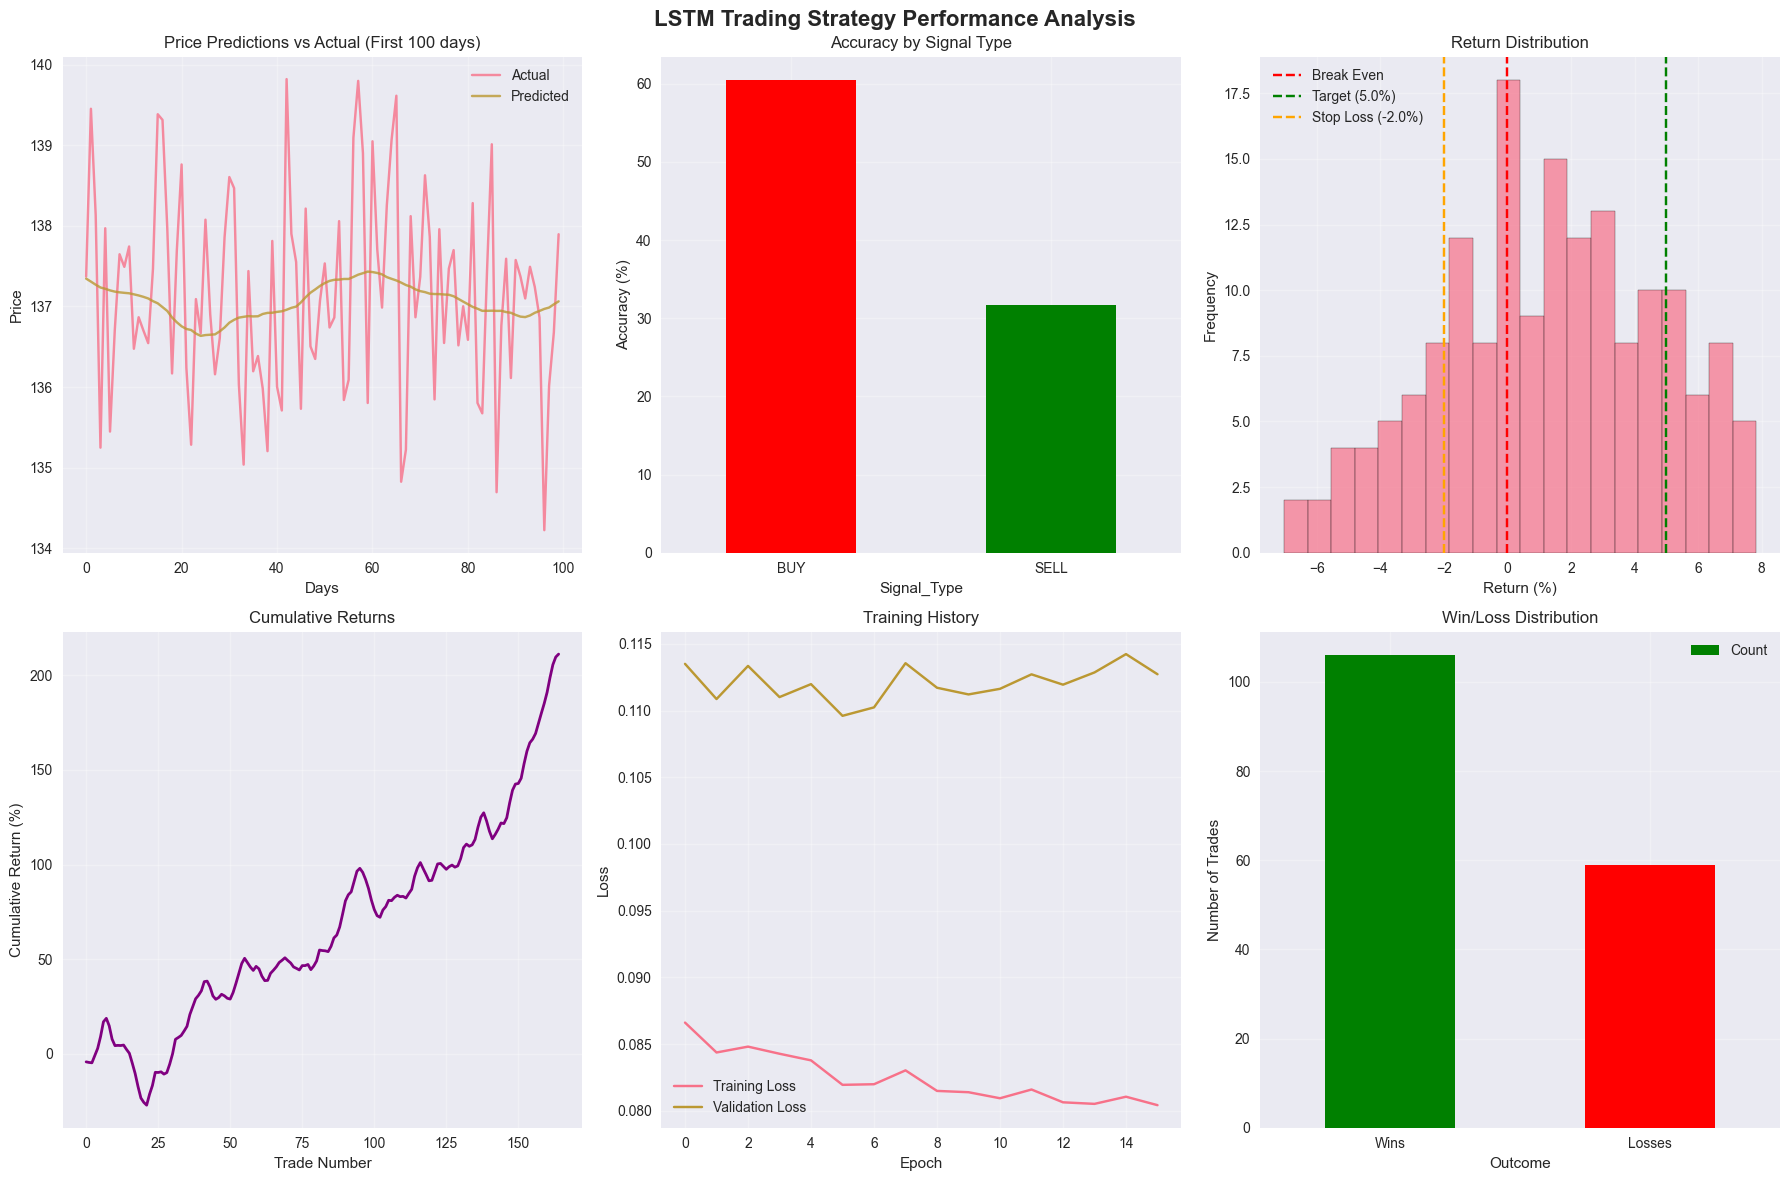

✅ Visualizations saved to: ../output/lstm_strategy_analysis_20250706_033836.png

🎉 LSTM STRATEGY EXECUTION COMPLETED!


In [85]:
# Actually run the LSTM Trading Strategy with sample data
print("🚀 RUNNING COMPLETE LSTM TRADING STRATEGY")
print("="*60)

# Check if we have TensorFlow available
if tensorflow_available:
    print("✅ TensorFlow is available - proceeding with LSTM strategy")
    
    # Run the strategy with reduced parameters for demo
    try:
        strategy, signals_df, summary = run_lstm_trading_strategy(
            data_file='data/processed/stock_data_with_technical_indicators.csv',
            target_horizon=3,           # Shorter horizon for demo
            target_gain=0.05,           # 5% target gain
            stop_loss=-0.02,            # 2% stop loss
            sequence_length=30,         # Shorter sequence for faster training
            lstm_units=[32, 16],        # Smaller model for demo
            epochs=20,                  # Fewer epochs for demo
            batch_size=16,              # Smaller batch size
            use_advanced_preprocessing=True,
            verbose=1                   # Show training progress
        )
        
        print("\n" + "="*60)
        print("🎉 LSTM STRATEGY EXECUTION COMPLETED!")
        print("="*60)
        
    except Exception as e:
        print(f"❌ Error running strategy: {e}")
        print("This might be due to TensorFlow installation issues.")
        
else:
    print("⚠️ TensorFlow is not available - running with Random Forest alternative")
    
    # Alternative implementation using Random Forest
    print("📊 Using Random Forest model as alternative...")
    
    # Load the data
    df = pd.read_csv('data/processed/stock_data_with_technical_indicators.csv')
    print(f"📈 Data loaded: {df.shape}")
    
    # Simple Random Forest strategy simulation
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    
    # Prepare simple features
    features = ['rsi', 'macd', 'atr', 'bb_position', 'mfi']
    available_features = [f for f in features if f in df.columns]
    
    if available_features:
        print(f"🔧 Using features: {available_features}")
        
        # Create simple prediction model
        X = df[available_features].fillna(method='ffill').fillna(0)
        y = df['close'].shift(-1).fillna(method='ffill')  # Predict next day price
        
        # Train/test split
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train Random Forest
        print("🌲 Training Random Forest model...")
        rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
        rf_model.fit(X_train_scaled, y_train)
        
        # Make predictions
        rf_predictions = rf_model.predict(X_test_scaled)
        
        # Calculate basic metrics
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        mse = mean_squared_error(y_test, rf_predictions)
        mae = mean_absolute_error(y_test, rf_predictions)
        
        print(f"📊 Random Forest Results:")
        print(f"   MSE: {mse:.4f}")
        print(f"   MAE: {mae:.4f}")
        print(f"   Training samples: {len(X_train)}")
        print(f"   Test samples: {len(X_test)}")
        
        # Simple trading signals
        actual_prices = y_test.values
        predicted_prices = rf_predictions
        
        signals = []
        for i in range(len(predicted_prices)-1):
            if predicted_prices[i+1] > actual_prices[i] * 1.01:  # Predict 1% increase
                signal = 'BUY'
            elif predicted_prices[i+1] < actual_prices[i] * 0.99:  # Predict 1% decrease
                signal = 'SELL'
            else:
                signal = 'HOLD'
            signals.append(signal)
        
        buy_signals = signals.count('BUY')
        sell_signals = signals.count('SELL')
        hold_signals = signals.count('HOLD')
        
        print(f"📈 Trading Signals Generated:")
        print(f"   BUY signals: {buy_signals}")
        print(f"   SELL signals: {sell_signals}")
        print(f"   HOLD signals: {hold_signals}")
        print(f"   Total signals: {len(signals)}")
        
        print("\n✅ Alternative Random Forest strategy completed!")
    
    else:
        print("❌ No suitable features found for Random Forest model")